# BentoML Example: Fast AI with Tabular data

**BentoML makes moving trained ML models to production easy:**

* Package models trained with **any ML framework** and reproduce them for model serving in production
* **Deploy anywhere** for online API serving or offline batch serving
* High-Performance API model server with *adaptive micro-batching* support
* Central hub for managing models and deployment process via Web UI and APIs
* Modular and flexible design making it *adaptable to your infrastrcuture*

BentoML is a framework for serving, managing, and deploying machine learning models. It is aiming to bridge the gap between Data Science and DevOps, and enable teams to deliver prediction services in a fast, repeatable, and scalable way.
Before reading this example project, be sure to check out the [Getting started guide](https://github.com/bentoml/BentoML/blob/master/guides/quick-start/bentoml-quick-start-guide.ipynb) to learn about the basic concepts in BentoML.


This notebook is based on fastai v1's cours v3 lesson 4.  It will train a model that predict salary range base on the data we provided.


![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=fast-ai&ea=fast-ai-salary-range-prediction&dt=fast-ai-salary-range-prediction)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#!pip install -q -U 'fastai<=1.0.61'

In [1]:
import fastai
fastai.__version__

'2.2.7'

In [2]:
from fastai.tabular.all import *
from fastai.vision.all import * 

## Prepare Training Data

In [3]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [4]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'
y_block = CategoryBlock()

In [5]:
splits = RandomSplitter()(range_of(df))
splits

((#26049) [4715,3367,32323,8043,4203,20804,21988,8273,29444,7534...],
 (#6512) [14250,4612,13885,2603,4639,5592,7046,2806,14712,29857...])

In [6]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)

In [7]:
to.classes

{'workclass': ['#na#', ' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ' Private', ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'],
 'education': ['#na#', ' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Preschool', ' Prof-school', ' Some-college'],
 'marital-status': ['#na#', ' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed'],
 'occupation': ['#na#', ' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service', ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support', ' Transport-moving'],
 'relationship': ['#na#', ' Husband', ' Not-in-family', ' Other-relative', ' Own-child', ' Unmarried', ' Wife'],
 'race': ['#na#', ' Amer-Indian-Eskimo', ' Asian-Pac-Island

In [8]:
dls = to.dataloaders()
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Asian-Pac-Islander,False,63.000000,135338.999379,9.0,<50k
1,Private,Some-college,Never-married,Machine-op-inspct,Other-relative,Asian-Pac-Islander,False,39.000000,160119.998435,10.0,<50k
2,Private,Bachelors,Married-civ-spouse,Machine-op-inspct,Husband,Black,False,49.000000,215389.000132,13.0,<50k
3,?,Some-college,Married-civ-spouse,?,Husband,White,False,72.000000,33607.994123,10.0,>=50k
4,Private,Bachelors,Never-married,Exec-managerial,Own-child,Black,False,23.999999,205843.999222,13.0,<50k
5,Private,HS-grad,Married-civ-spouse,Other-service,Husband,White,False,31.000000,59083.002010,9.0,<50k
6,Private,Some-college,Never-married,Sales,Not-in-family,White,False,25.000000,262977.999321,10.0,<50k
7,Federal-gov,Prof-school,Married-civ-spouse,Exec-managerial,Husband,White,False,55.000000,305850.002047,15.0,>=50k
8,Local-gov,HS-grad,Never-married,Prof-specialty,Own-child,Black,False,27.000000,151625.999061,9.0,<50k
9,Private,11th,Never-married,Sales,Own-child,White,False,18.000000,375515.002547,7.0,<50k


## Model Training

In [9]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=0.007585775572806597)

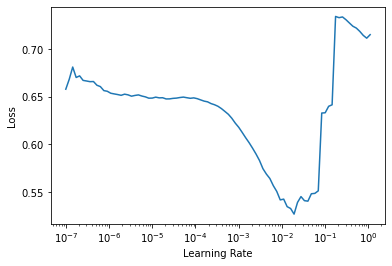

In [10]:
learn.lr_find()

In [11]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.363383,0.369927,0.835688,00:05


In [12]:
df.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k


In [13]:
df2 = pd.read_csv("test.csv")
df2

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

In [14]:
row = df.iloc[0] # sample input date for testing

learn.predict(row)

(   workclass  education  marital-status  occupation  relationship  race  \
 0        5.0        8.0             3.0         0.0           6.0   5.0   
 
    education-num_na       age    fnlwgt  education-num  salary  
 0               1.0  0.764949 -0.835987       0.749979     1.0  ,
 tensor(1),
 tensor([0.3753, 0.6247]))

In [15]:
row.values

array([49, ' Private', 101320, ' Assoc-acdm', 12.0, ' Married-civ-spouse',
       nan, ' Wife', ' White', ' Female', 0, 1902, 40, ' United-States',
       '>=50k'], dtype=object)

In [16]:
dl = learn.dls.test_dl(df.iloc[:1], rm_type_tfms=None, num_workers=0)
print(dl.xs)
result = learn.get_preds(dl=dl,with_input=True,with_decoded=True)
result

   workclass  education  marital-status  occupation  relationship  race  \
0          5          8               3           0             6     5   

   education-num_na       age    fnlwgt  education-num  
0                 1  0.764949 -0.835987       0.749979  


((tensor([[5, 8, 3, 0, 6, 5, 1]]), tensor([[ 0.7649, -0.8360,  0.7500]])),
 tensor([[0.3753, 0.6247]]),
 tensor([[1]], dtype=torch.int8),
 tensor([1]))

In [24]:
dl.xs.values

array([[ 5.        ,  8.        ,  3.        ,  0.        ,  6.        ,
         5.        ,  1.        ,  0.76724756, -0.83757281,  0.75259128]])

#### create new test data
df_test = df.iloc[2:3,:]
to_tst = to.new(df_test)
to_tst.process()
to_tst.items.head()

tst_dl = dls.valid.new(to_tst)
tst_dl.show_batch()

dl = learn.dls.test_dl(df_test, rm_type_tfms=None, num_workers=0)
result = learn.get_preds(dl=dl)
result

In [17]:
to.procs[2].vocab

['<50k', '>=50k']

In [26]:
to.procs[2]

Categorize -- {'vocab': None, 'sort': True, 'add_na': False}:
encodes: (Tabular,object) -> encodes
(object,object) -> encodes
decodes: (Tabular,object) -> decodes
(object,object) -> decodes

In [18]:
learn.predict(df.iloc[0])

(   workclass  education  marital-status  occupation  relationship  race  \
 0        5.0        8.0             3.0         0.0           6.0   5.0   
 
    education-num_na       age    fnlwgt  education-num  salary  
 0               1.0  0.764949 -0.835987       0.749979     1.0  ,
 tensor(1),
 tensor([0.3753, 0.6247]))

In [19]:
df.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k


In [20]:
dl.xs.T[0]

workclass           5.000000
education           8.000000
marital-status      3.000000
occupation          0.000000
relationship        6.000000
race                5.000000
education-num_na    1.000000
age                 0.764949
fnlwgt             -0.835987
education-num       0.749979
Name: 0, dtype: float64

In [21]:
learn.predict(dl.xs.T[0])  #####RESULTADO ERRADO !!!!

(   workclass  education  marital-status  occupation  relationship  race  \
 0        0.0        0.0             0.0         0.0           0.0   0.0   
 
    education-num_na       age    fnlwgt  education-num  salary  
 0               1.0 -2.769119 -1.798856      -3.649725     0.0  ,
 tensor(0),
 tensor([1.0000e+00, 1.3376e-08]))

In [22]:
learn.get_preds(dl=dl)

(tensor([[0.3753, 0.6247]]), tensor([[1]], dtype=torch.int8))

In [23]:
####  dados de arquivo

import pandas
df2 = pd.read_csv("test.csv")
dl = learn.dls.test_dl(df2, rm_type_tfms=None, num_workers=0)
result = learn.get_preds(dl=dl)
result

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

# # CONCLUSÃO - get_preds(dl)    x predict(df)

## Create BentoService for model serving

In [24]:
%%writefile tabular_csv.py

import bentoml,json
import pandas as pd
from bentoml.frameworks.fastai import FastaiModelArtifact
from bentoml.adapters import FileInput,DataframeInput
@bentoml.artifacts([FastaiModelArtifact('learner')])
@bentoml.env(infer_pip_packages=True)
class FastaiTabularModel(bentoml.BentoService):
    
    @bentoml.api(input=DataframeInput(), batch=True)  ## preisa ser True
    def predict(self, df):
        dl = self.artifacts.learner.dls.test_dl(df.iloc[:1,:],rm_type_tfms=None, num_workers=0,with_input=True)
        print("dl.xs= ",dl.xs)
        result  = self.artifacts.learner.get_preds(dl=dl)
        return [[result]]


Overwriting tabular_csv.py


## Save BentoService to file archive

In [25]:
#from bentoml.adapters import FileInput

In [35]:
#!bentoml  list

In [36]:
#!bentoml delete FastaiTabularModel:20210304202743_0335AD
    
    

In [26]:
# 1) import the custom BentoService defined above
from tabular_csv import FastaiTabularModel

# 2) `pack` it with required artifacts
svc = FastaiTabularModel()
svc.pack('learner', learn)

# 3) save your BentoSerivce
saved_path = svc.save()

[2021-03-11 21:17:43,736] INFO - Detected zipimporter <zipimporter object "/home/ec2-user/anaconda3/lib/python3.7/site-packages/locket-0.2.1-py3.7.egg">
[2021-03-11 21:17:43,739] WARNING - BentoML by default does not include spacy and torchvision package when using FastaiModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService


/home/ec2-user/anaconda3/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


[2021-03-11 21:17:44,741] INFO - BentoService bundle 'FastaiTabularModel:20210311211744_D5DE92' saved to: /home/ec2-user/bentoml/repository/FastaiTabularModel/20210311211744_D5DE92


In [27]:
saved_path

'/home/ec2-user/bentoml/repository/FastaiTabularModel/20210311211744_D5DE92'

In [39]:
#import bentoml
#import pandas as pd
#bento_svc = bentoml.load(saved_path)

## REST API Model Serving


To start a REST API model server with the BentoService saved above, use the bentoml serve command:

In [28]:
pd.options.display.width = 0

In [ ]:
!bentoml serve FastaiTabularModel:latest --verbose

[2021-03-11 21:17:59,613] DEBUG - Loaded logging configuration from default configuration and environment variables.
[2021-03-11 21:17:59,613] DEBUG - Setting debug mode: ON for current session
[2021-03-11 21:17:59,686] DEBUG - Creating local YataiService instance
/home/ec2-user/anaconda3/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
[2021-03-11 21:17:59,805] DEBUG - Upgrading tables to the latest revision
[2021-03-11 21:18:00,037] INFO - Getting latest version FastaiTabularModel:20210311211744_D5DE92
[2021-03-11 21:18:00,037] INFO - Starting BentoML API server in development mode..
[2021-03-11 21:18:00,274] DEBUG - adding locket-0.2.1-py3.7.egg to sys.path
[2021-03-11 21:18:00,489] INFO - Detected zipimporter <zipimporter 

If you are running this notebook from Google Colab, you can start the dev server with `--run-with-ngrok` option, to gain acccess to the API endpoint via a public endpoint managed by [ngrok](https://ngrok.com/):

resposta = !curl -X POST "http://127.0.0.1:5000/predict" \
    -H "Content-Type: text/csv" \
    --data-binary @test.csv

In [24]:
#!bentoml serve FastaiTabularModel:latest --run-with-ngrok

In [25]:
!curl -X POST \
  http://localhost:5000/predict \
  -H 'Content-Type: application/json' \
  -d '[{  "age": 49,  \
        "workclass": "Private", \
        "fnlwgt": 101320,   \
        "education": "Assoc-acdm",  \
        "education-num": 12.0,   \
        "marital-status": "Married-civ-spouse",  \
        "occupation": "",   \
        "relationship": "Wift",   \
        "race": "White",   \
        "sex": "Female",   \
        "capital-gain": 0, \
        "capital-loss": 1902, \
        "hours-per-week": 40,   \
        "native-country": "United-States",  \
        "salary": ">=50k"}]'

curl: (7) Failed to connect to localhost port 5000: Connection refused


### Send prediction requeset to the REST API server

#### JSON Request

```bash
curl -X POST \
  http://localhost:5000/predict \
  -H 'Content-Type: application/json' \
  -d '[{
  "age": 49,
  "workclass": "Private",
  "fnlwgt": 101320,
  "education": "Assoc-acdm",
  "education-num": 12.0,
  "marital-status": "Married-civ-spouse",
  "occupation": "",
  "relationship": "Wift",
  "race": "White",
  "sex": "Female",
  "capital-gain": 0,
  "capital-loss": 1902,
  "hours-per-week": 40,
  "native-country": "United-States",
  "salary": ">=50k"
}]'
```

#### CSV Request

```bash
curl -X POST "http://127.0.0.1:5000/predict" \
    -H "Content-Type: text/csv" \
    --data-binary @test.csv
```

In [67]:
!curl -X POST "http://127.0.0.1:5000/predict" \
    -H "Content-Type: text/csv" \
    --data-binary @test.csv

curl: (7) Failed to connect to 127.0.0.1 port 5000: Connection refused


## Containerize model server with Docker


One common way of distributing this model API server for production deployment, is via Docker containers. And BentoML provides a convenient way to do that.

Note that docker is **not available in Google Colab**. You will need to download and run this notebook locally to try out this containerization with docker feature.

If you already have docker configured, simply run the follow command to product a docker container serving the IrisClassifier prediction service created above:

In [36]:
!bentoml containerize FastaiTabularModel:latest

/home/ec2-user/anaconda3/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
[2021-03-04 18:26:29,343] INFO - Getting latest version FastaiTabularModel:20210304181504_B25044
Found Bento: /home/ec2-user/bentoml/repository/FastaiTabularModel/20210304181504_B25044
Containerizing FastaiTabularModel:20210304181504_B25044 with local YataiService and docker daemon from local environment\Build container image: fastaitabularmodel:20210304181504_B25044


In [38]:
!docker run -p 5000:5000 fastaitabularmodel:20210304181504_B25044 --verbose

[2021-03-04 18:35:27,824] DEBUG - Loaded logging configuration from default configuration and environment variables.
[2021-03-04 18:35:27,824] DEBUG - Setting debug mode: ON for current session
[2021-03-04 18:35:27,824] INFO - Starting BentoML API server in production mode..
[2021-03-04 18:35:27,985] INFO - get_gunicorn_num_of_workers: 3, calculated by cpu count
[2021-03-04 18:35:27,988] DEBUG - Setting up prometheus_multiproc_dir: /root/bentoml/prometheus_multiproc_dir
[2021-03-04 18:35:27 +0000] [1] [INFO] Starting gunicorn 20.0.4
[2021-03-04 18:35:27 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2021-03-04 18:35:27 +0000] [1] [INFO] Using worker: sync
[2021-03-04 18:35:27 +0000] [11] [INFO] Booting worker with pid: 11
[2021-03-04 18:35:28 +0000] [12] [INFO] Booting worker with pid: 12
[2021-03-04 18:35:28 +0000] [13] [INFO] Booting worker with pid: 13
[2021-03-04 18:35:28,236] WARNING - Saved BentoService Python version mismatch: loading BentoService bundle created with P

## Load saved BentoService

bentoml.load is the API for loading a BentoML packaged model in python:

In [14]:
from bentoml import load

svc = load(saved_path)
print(svc.predict(df.iloc[0:1]))

[2020-10-01 14:45:29,278] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.1, but loading from BentoML version 0.9.1+1.g0655cf16.dirty
[2020-10-01 14:45:29,279] WARNING - Module `tabular_csv` already loaded, using existing imported module.
[2020-10-01 14:45:29,286] WARNING - pip package requirement pandas already exist
[2020-10-01 14:45:29,287] WARNING - BentoML by default does not include spacy and torchvision package when using FastaiModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2020-10-01 14:45:29,288] WARNING - pip package requirement torch already exist
[2020-10-01 14:45:29,290] WARNING - pip package requirement fastai<2.0.0 already exist
['>=50k']


## Launch inference job from CLI

BentoML cli supports loading and running a packaged model from CLI. With the DataframeInput adapter, the CLI command supports reading input Dataframe data from CLI argument or local csv or json files:

In [ ]:
!wget https://raw.githubusercontent.com/bentoml/gallery/master/fast-ai/salary-range-prediction/test.csv
!bentoml run FastaiTabularModel:latest predict \
    --input-file test.csv

# Deployment Options

If you are at a small team with limited engineering or DevOps resources, try out automated deployment with BentoML CLI, currently supporting AWS Lambda, AWS SageMaker, and Azure Functions:
- [AWS Lambda Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_lambda.html)
- [AWS SageMaker Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_sagemaker.html)
- [Azure Functions Deployment Guide](https://docs.bentoml.org/en/latest/deployment/azure_functions.html)

If the cloud platform you are working with is not on the list above, try out these step-by-step guide on manually deploying BentoML packaged model to cloud platforms:
- [AWS ECS Deployment](https://docs.bentoml.org/en/latest/deployment/aws_ecs.html)
- [Google Cloud Run Deployment](https://docs.bentoml.org/en/latest/deployment/google_cloud_run.html)
- [Azure container instance Deployment](https://docs.bentoml.org/en/latest/deployment/azure_container_instance.html)
- [Heroku Deployment](https://docs.bentoml.org/en/latest/deployment/heroku.html)

Lastly, if you have a DevOps or ML Engineering team who's operating a Kubernetes or OpenShift cluster, use the following guides as references for implementating your deployment strategy:
- [Kubernetes Deployment](https://docs.bentoml.org/en/latest/deployment/kubernetes.html)
- [Knative Deployment](https://docs.bentoml.org/en/latest/deployment/knative.html)
- [Kubeflow Deployment](https://docs.bentoml.org/en/latest/deployment/kubeflow.html)
- [KFServing Deployment](https://docs.bentoml.org/en/latest/deployment/kfserving.html)
- [Clipper.ai Deployment Guide](https://docs.bentoml.org/en/latest/deployment/clipper.html)

